# Land value regression problem:
### Problem statement:
Based on the dataset of real estate transactions carried out on the entire French territory since 2014, we want to be able to create a model that predicts value / unit area. 
### Method:
For this problem, we're using a k Nearest Neighbor regressor algorithm. The features are the land coordinates and the label is value / area.
### Challenges:
The data is unknown to the author. I need to learn the data myself first to be able to create a suitable model.

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import numpy as np
import pandas as pd
from shapely import wkt
from pyproj import Geod
from shapely.geometry import Polygon
from math import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import neighbors
%matplotlib inline

#### Preventing the notebook from showing warnings (it is just a personal preference).

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data
There are three files associated with this problem:
1. **valeursfoncieres-2020.txt**, which includes all the real estate transactions carried out in the French territory since 2014. This file does not include geographical coordinates, but it does include land value and parsed IDs of the land.
2. **parcelles.zip**, which includes the geographical information (coordinates) of the lands, followed by the land ID which can be used to match with the land value in the text file.
3. **notice-descriptive-du-fichier-dvf-20210809_EN.pdf**, which is a text, explaining the data inside the txt file. 

### Getting to know the data

#### Reading the shape file using Geopandas into a DataFrame

In [3]:
parcelles = gpd.read_file(r'parcelles.shp')

The only column with non-object data type is contenance which we see when we use the "describe" method:

In [4]:
parcelles.describe()

,contenance
count,77720.000000
mean,841.145188
std,4785.523759
min,0.000000
25%,172.000000
50%,297.000000
75%,570.000000
max,481843.000000


The DataFrame information. As it can be seen here, there are no "NaN" values inside the parcelles DataFrame.  
Out of 9 columns, 7 have strings data type, 1 is a geometry object and one is an integer.

In [5]:
parcelles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77720 entries, 0 to 77719
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          77720 non-null  object  
 1   commune     77720 non-null  object  
 2   prefixe     77720 non-null  object  
 3   section     77720 non-null  object  
 4   numero      77720 non-null  object  
 5   contenance  77720 non-null  int64   
 6   created     77720 non-null  object  
 7   updated     77720 non-null  object  
 8   geometry    77720 non-null  geometry
dtypes: geometry(1), int64(1), object(7)
memory usage: 5.3+ MB


First look at the parcelles data:

In [6]:
parcelles.head()

,id,commune,prefixe,section,numero,contenance,created,updated,geometry
0,75101000AB0002,75101,000,AB,2,45688,2006-10-06,2016-07-21,"POLYGON ((650234.002 6862851.438, 650234.279 6..."
1,75101000AB0001,75101,000,AB,1,1731,2006-10-06,2016-07-21,"POLYGON ((650350.149 6862820.696, 650346.848 6..."
2,75101000AC0002,75101,000,AC,2,49342,2006-10-06,2016-07-21,"POLYGON ((650388.357 6862947.325, 650294.933 6..."
3,75101000AC0001,75101,000,AC,1,993,2006-10-06,2016-07-21,"POLYGON ((650448.438 6863052.996, 650447.612 6..."
4,75101000AD0001,75101,000,AD,1,64760,2006-10-06,2016-07-21,"POLYGON ((650915.759 6862686.995, 650811.369 6..."


The geometry column seems to have the polygon coordinates of the land.  
Looking at some of the properties of the polygon:

In [7]:
## coordinate values for the first polygon with id: 75101000AB0002
list(parcelles['geometry'][0].exterior.coords)

[(650234.002498897, 6862851.438287678),
 (650234.2791882373, 6862852.047509729),
 (650233.9401427881, 6862853.573860253),
 (650231.3118064834, 6862865.316904626),
 (650230.9727626524, 6862866.843255492),
 (650230.5709981532, 6862867.046867041),
 (650232.2019779927, 6862870.724689496),
 (650231.6394889163, 6862871.007521732),
 (650287.167182263, 6862977.5050188145),
 (650287.8172176641, 6862977.165840372),
 (650288.5114828765, 6862978.561001522),
 (650289.4880437208, 6862980.365179981),
 (650288.3923298983, 6862980.919462877),
 (650294.9332776567, 6862993.373327287),
 (650388.3574574998, 6862947.325183289),
 (650446.240667786, 6862918.807359269),
 (650567.5829730285, 6862859.0015006885),
 (650567.1201653692, 6862858.071371834),
 (650497.6480209865, 6862717.930246055),
 (650487.3916250899, 6862723.133084894),
 (650234.002498897, 6862851.438287678)]

In order to create features out of the polygon, I use the centroid function to find the centre of each polygon, e.g.:

In [8]:
parcelles['geometry'][0].centroid.wkt

'POINT (650400.1932244125 6862856.473951302)'

The above method returns a string which includes the centroid coordinates.

Now we call two of the polygons without any methods:

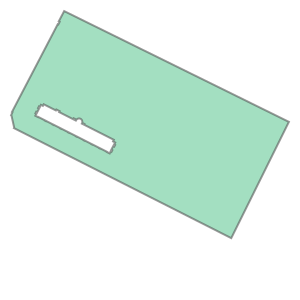

In [9]:
parcelles['geometry'][0]

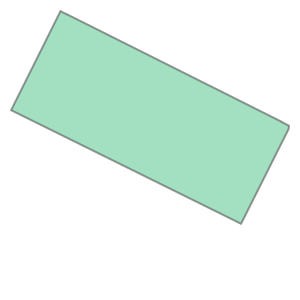

In [10]:
parcelles['geometry'][4]

Finding the area of the polygon using .area method:

In [11]:
parcelles['geometry'][0].area

45720.195454293425

#### Reading the text file using pandas into a DataFrame
Accordingly, going through the same process to learn more about the data

In [12]:
data = pd.read_csv(r'valeursfoncieres-2020.txt', sep='|',low_memory=False)

In [13]:
data.shape

(3484957, 43)

In [14]:
data.size

149853151

In [15]:
sum(data.dtypes == object)

22

22 columns contain strings

In [16]:
data.head()

,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2020,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,1061.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/01/2020,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,BT,NaN,85.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/01/2020,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,1115.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/01/2020,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,1940.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,02/01/2020,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,1148.0


Number of NaNs in the whole DataFrame:

In [17]:
data.isna().sum().sum()

85926409

According to the file description, the first 7 columns do not include any meaningful information and are NaNs. As you can see below, as an example, the column "5 Articles CGI" icludes the same number of NaNs as rows.

In [18]:
data['5 Articles CGI'].isna().sum()

3484957

Again, according to the file description, the most important information for this project lies in these columns:  
1. Commune: Name of the city
2. Code commune: digit code of the region inside the city
3. Code departement: Digit code of the city
4. Section: Another identifier of the land
5. No plan: Another identifier of the land
6. Date mutation: the date the deed was signed
7. Surface terrain: whole area of the land
8. Valeur fonciere: Land value  
These columns are read and put into a new DF

In [19]:
dataset = data[['Commune','Code commune', 'Code departement','Section', 'No plan', 'Date mutation', 'Surface terrain','Valeur fonciere']]

In [20]:
dataset.size

27879656

In [21]:
dataset.isna().sum().sum()

1145601

Checking to see if all the dates are valid:

In [22]:
dataset['Date mutation'].isna().sum()

0

Changing date string into datetime object

In [23]:
dataset['Date mutation'] = pd.to_datetime(dataset['Date mutation'], format = '%d/%m/%Y')

Checking for the name of the cities to find a pattern for Paris:

In [24]:
dataset['Commune'].unique()

array(['CEYZERIAT', 'LAIZ', 'PERONNAS', ..., 'PARIS 15', 'PARIS 13',
       'PARIS 14'], dtype=object)

Checking for the code of the city, "code departement" of Paris:

In [25]:
dataset[dataset['Commune'] == 'PARIS 14']['Code departement'].unique()

array(['75'], dtype=object)

Since we are only interested in Paris, and Paris's code is 75, we look only for that and create a new DF:

In [26]:
paris_data = dataset[dataset['Code departement'] == '75']
paris_data['Commune'].unique()

array(['PARIS 08', 'PARIS 01', 'PARIS 03', 'PARIS 20', 'PARIS 10',
       'PARIS 17', 'PARIS 19', 'PARIS 02', 'PARIS 18', 'PARIS 09',
       'PARIS 04', 'PARIS 06', 'PARIS 07', 'PARIS 05', 'PARIS 16',
       'PARIS 11', 'PARIS 12', 'PARIS 15', 'PARIS 13', 'PARIS 14'],
      dtype=object)

There are 20 Paris districts. 

In [27]:
paris_data.shape

(54549, 8)

In [28]:
paris_data.size

436392

In [29]:
paris_data.isna().sum().sum()

49731

In [30]:
paris_data.dtypes

Commune                     object
Code commune                 int64
Code departement            object
Section                     object
No plan                      int64
Date mutation       datetime64[ns]
Surface terrain            float64
Valeur fonciere             object
dtype: object

By looking at the id inside the parcelles and the combination of cadastral data inside the paris_data DF, I concluded that the id is the combination of:  
Code departement + code commune + '000' + Section + No plan  
  
  Therefore, in order to create the id we need to change No plan and code commune to object types instead of int64

In [31]:
paris_data['No plan'] = paris_data['No plan'].astype(str)

In [32]:
paris_data['Code commune'] = paris_data['Code commune'].astype(str)

Looking for rows where land value (Valeur Fonciere) is NaN and remove those rows.

In [33]:
print(paris_data['Valeur fonciere'].isna().sum())
paris_data = paris_data[paris_data['Valeur fonciere'].notna()]

192


Then, changing the Valeur fonciere from object type to float64.

In [34]:
paris_data['Valeur fonciere'] = paris_data['Valeur fonciere'].apply(lambda x: x[:-3])

In [35]:
paris_data['Valeur fonciere'] = paris_data['Valeur fonciere'].astype('float64')

In [36]:
paris_data.dtypes

Commune                     object
Code commune                object
Code departement            object
Section                     object
No plan                     object
Date mutation       datetime64[ns]
Surface terrain            float64
Valeur fonciere            float64
dtype: object

Based on the id from parcelles DF, I concluded that the No plan should be a 4 character string. Therefore, adding zeros to the left of the No plan to create the id in the correct way.  
Example:  
	id : 75101000AB0002  
    code departement: 75, code commune: 101, prefix: 000 (always), section: AB, No Plan: 0002, instead of just 2.


In [37]:
paris_data['No plan'] = paris_data['No plan'].apply(lambda x: '0'*(4-len(x)) + x)

Generating id

In [38]:
paris_data['id'] = paris_data.apply(lambda row: row['Code departement'] + row['Code commune'] + '000' + row['Section'] + row['No plan'] , axis=1)
paris_data

,Commune,Code commune,Code departement,Section,No plan,Date mutation,Surface terrain,Valeur fonciere,id
3430408,PARIS 08,108,75,BS,0136,2020-01-02,NaN,268800.0,75108000BS0136
3430409,PARIS 01,101,75,BC,0041,2020-01-06,NaN,878378.0,75101000BC0041
3430410,PARIS 01,101,75,BC,0041,2020-01-06,NaN,878378.0,75101000BC0041
3430411,PARIS 03,103,75,AV,0006,2020-01-10,NaN,680000.0,75103000AV0006
3430412,PARIS 03,103,75,AK,0080,2020-01-03,NaN,852000.0,75103000AK0080
...,...,...,...,...,...,...,...,...,...
3484952,PARIS 04,104,75,AW,0019,2020-12-16,447.0,1937500.0,75104000AW0019
3484953,PARIS 04,104,75,AW,0019,2020-12-16,447.0,1937500.0,75104000AW0019
3484954,PARIS 04,104,75,AW,0019,2020-12-16,447.0,1937500.0,75104000AW0019
3484955,PARIS 04,104,75,AW,0019,2020-12-16,447.0,1937500.0,75104000AW0019


number of unique ids in paris_data DF:

In [39]:
paris_data['id'].nunique()

20348

In [40]:
paris_data.shape

(54357, 9)

Checking for duplicate rows and removing them

In [41]:
paris_data = paris_data.drop_duplicates()

Number of unique ids should not change:

In [42]:
paris_data['id'].nunique()

20348

Checking the actual area from the dataset.

In [43]:
paris_data['Surface terrain'].isna().sum()

38033

Most of the area values are NaNs. Therefore I will be using the polygon .area method to calculate the area.

In [44]:
paris_data.shape

(38654, 9)

##### Strange cases

Looking to see the difference between number of rows and number of unique ids.

In [45]:
len(paris_data) - paris_data['id'].nunique()

18306

This is an strange case. Let's investigate it more. As an example I chose id: 75101000BC0041

In [46]:
paris_data[paris_data['id'] == '75101000BC0041']

,Commune,Code commune,Code departement,Section,No plan,Date mutation,Surface terrain,Valeur fonciere,id
3430409,PARIS 01,101,75,BC,0041,2020-01-06,NaN,878378.0,75101000BC0041
3431922,PARIS 01,101,75,BC,0041,2020-05-18,NaN,2200.0,75101000BC0041


The two ids have the same information, except date and value. Let's go back to the unprocessed data:

In [47]:
data[data['Valeur fonciere'] == '878378,00'][['No voie', 'Code voie', 'Voie', 'Code postal', 'Code departement']]

,No voie,Code voie,Voie,Code postal,Code departement
3430409,9.0,5888,DE LA MADELEINE,75001.0,75
3430410,9.0,5888,DE LA MADELEINE,75001.0,75


In [48]:
d = data[data['Valeur fonciere'] == '2200,00']
d[d['Code commune']==101][['No voie', 'Code voie', 'Voie', 'Code postal', 'Code departement']]

,No voie,Code voie,Voie,Code postal,Code departement
3431922,9.0,5888,DE LA MADELEINE,75001.0,75


Street name, postal code and everything else are the same. Except value and mutation date. I could not find any information about this in the description pdf. However, since there is only one instance of each id in the parcelles DF, I took the id with the higher value. 

##### Preparing the data

Transferring value information from paris_data to parcelles DF based on ids.

In [49]:
parcelles['value'] = ''

In [50]:
for i in parcelles['id'].unique():
    if i in paris_data['id'].unique():
        m = max(paris_data[paris_data['id'] == i]['Valeur fonciere']) ### taking max values for strange edge cases.
        parcelles.loc[parcelles['id'] == i,'value'] = m

Removing rows where there are no land values for:

In [51]:
parcelles = parcelles[parcelles['value'] != '']

Removing other unnecessary columns. 

In [52]:
parcelles.drop(['commune','prefixe', 'section', 'numero', 'contenance', 'created', 'updated'], inplace=True, axis = 1)

Reseting index in place and without adding index as a new column

In [53]:
parcelles.reset_index(inplace=True, drop=True)

##### Adding geographical information

Adding the centroid

In [54]:
parcelles['centroid'] = parcelles.apply(lambda x: x['geometry'].centroid.wkt[7:41], axis=1)

Adding the area

In [55]:
parcelles['area'] = parcelles.apply(lambda x: x['geometry'].area, axis=1)

Adding value per unit area

In [56]:
parcelles['value per unit area'] = parcelles.apply(lambda x: x['value'] / x['area'], axis=1)

Transforming the centroid tuple to two separate features coord1 and coord2. 

In [57]:
parcelles['coord1'] = parcelles.apply(lambda x: float(x['centroid'].split()[0]), axis=1)
parcelles['coord2'] = parcelles.apply(lambda x: float(x['centroid'].split()[1][:-1]), axis=1)

In [58]:
parcelles

,id,geometry,value,centroid,area,value per unit area,coord1,coord2
0,75104000AB0024,"POLYGON ((652387.160 6862568.564, 652376.080 6...",1095050.0,652388.4665793044 6862578.89401630,769.737559,1422.627736,652388.466579,6.862579e+06
1,75104000AB0007,"POLYGON ((652302.282 6862535.980, 652316.008 6...",900000.0,652309.0483151362 6862525.34195575,270.228614,3330.513324,652309.048315,6.862525e+06
2,75104000AB0005,"POLYGON ((652321.329 6862524.514, 652321.672 6...",1170000.0,652326.5254815343 6862510.59281880,367.888735,3180.309395,652326.525482,6.862511e+06
3,75104000AB0006,"POLYGON ((652317.812 6862515.258, 652314.441 6...",9250.0,652305.5401049532 6862513.59320300,258.099244,35.838927,652305.540105,6.862514e+06
4,75107000AB0020,"POLYGON ((650904.873 6862289.772, 650898.141 6...",1421000.0,650881.7360123787 6862291.79811618,1980.196897,717.605407,650881.736012,6.862292e+06
...,...,...,...,...,...,...,...,...
20332,75120000EC0022,"POLYGON ((656703.246 6861090.670, 656719.419 6...",892760.0,656737.9322804684 6861070.34990130,2927.089228,304.999243,656737.932280,6.861070e+06
20333,75120000EC0020,"POLYGON ((656773.321 6861028.299, 656771.763 6...",271000.0,656762.835613881 6861021.757546067,296.599344,913.690490,656762.835614,6.861022e+06
20334,75120000EC0025,"POLYGON ((656756.551 6861110.777, 656757.578 6...",250000.0,656769.9869474501 6861122.92055497,681.156996,367.022583,656769.986947,6.861123e+06
20335,75120000EC0028,"POLYGON ((656758.172 6861152.886, 656758.347 6...",270705.0,656765.142739725 6861147.597472253,301.293131,898.477171,656765.142740,6.861148e+06


Final check to see if the datatypes are correct

In [59]:
parcelles.dtypes

id                       object
geometry               geometry
value                    object
centroid                 object
area                    float64
value per unit area     float64
coord1                  float64
coord2                  float64
dtype: object

##### Creating the final DataFrame

In [60]:
final_data = parcelles[['coord1','coord2','value per unit area']]
final_data

,coord1,coord2,value per unit area
0,652388.466579,6.862579e+06,1422.627736
1,652309.048315,6.862525e+06,3330.513324
2,652326.525482,6.862511e+06,3180.309395
3,652305.540105,6.862514e+06,35.838927
4,650881.736012,6.862292e+06,717.605407
...,...,...,...
20332,656737.932280,6.861070e+06,304.999243
20333,656762.835614,6.861022e+06,913.690490
20334,656769.986947,6.861123e+06,367.022583
20335,656765.142740,6.861148e+06,898.477171


In [61]:
final_data['value per unit area'].describe()

count    2.033700e+04
mean     5.289143e+03
std      2.363298e+05
min      0.000000e+00
25%      6.365596e+02
50%      1.407298e+03
75%      2.817730e+03
max      3.357087e+07
Name: value per unit area, dtype: float64

## Training

#### Shuffling the data and train / test split

In [62]:
final_data = shuffle(final_data)

In [82]:
train , test = train_test_split(final_data, test_size = 0.3)

x_train = train.drop('value per unit area', axis=1)
y_train = train['value per unit area']

x_test = test.drop('value per unit area', axis = 1)
y_test = test['value per unit area']

#### Using kNeighborsRegressor of sklearn in order to train the model.
I am choosing MAE over RMSE due to the fact that RMSE penalized outliers much more than MAE and since I don't know the data in depth, I need to be more conservative. 

As a rule of thumb, the value of k in the algorithm needs to be sqrt(n) where n is the sample size. However, I am changing the value of k in steps of 10, from 5, to sqrt(n) + 10.

In [85]:
mae = []

for k in range(5, int(sqrt(len(final_data)))+10, 10):
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mae.append(mean_absolute_error(y_test,pred))
    print(f'MAE value for k = {k}, is: {mean_absolute_error(y_test,pred)}')
    

MAE value for k = 5, is: 4657.926521897076
MAE value for k = 15, is: 5073.352302071093
MAE value for k = 25, is: 5299.612635631734
MAE value for k = 35, is: 5291.064993881266
MAE value for k = 45, is: 6101.318284013806
MAE value for k = 55, is: 5831.270210024911
MAE value for k = 65, is: 5625.202838964803
MAE value for k = 75, is: 5707.274413611897
MAE value for k = 85, is: 5519.500224043084
MAE value for k = 95, is: 5530.526939131295
MAE value for k = 105, is: 5433.581426541405
MAE value for k = 115, is: 5352.298616652516
MAE value for k = 125, is: 5234.995889529054
MAE value for k = 135, is: 5171.981928508194
MAE value for k = 145, is: 5080.125605262487


Plotting the test MAE with respect to the different k values. We clearly see that for the k = 5 we have the best performance. 

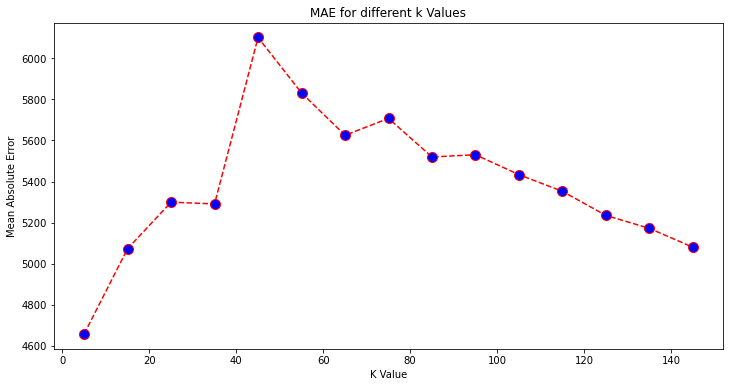

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(range(5, int(sqrt(len(final_data))+10), 10), mae, color='red', 
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
         
plt.title('MAE for different k Values')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')
plt.show()